**"Perform multiclass classification on Cifar 100 dataset using transfer learning. Data set can be obtained from Kaggle"**

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import densenet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

169017344/169001437 [==============================] - 2s 0us/step


In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [ ]:
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

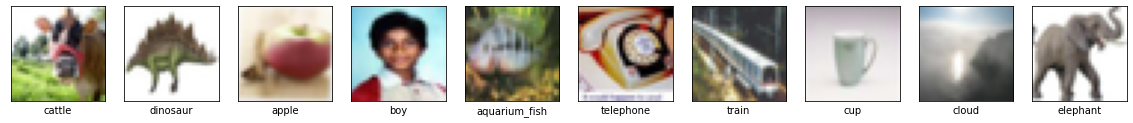

In [ ]:
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="gray")
    plt.xlabel(labels[y_train[i].astype(int)[0]])
plt.show()

In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

In [ ]:
input_shape=(32, 32, 3)
n_classes=len(labels)
base_model = densenet.DenseNet121(input_shape=input_shape,
                                  weights="imagenet",
                                  include_top=False,
                                  pooling='avg')

for layer in base_model.layers[:-5]:
    layer.trainable = False

for layer in base_model.layers[-5:]:
    layer.trainable = True

In [ ]:
x = base_model.output
x = Dense(128)(x)
x = Activation('relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
data = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

data.fit(X_train)

In [19]:
model_checkpointer = ModelCheckpoint('cifar100_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(data.flow(X_train, y_train, batch_size=128, shuffle=True), validation_data=(X_valid, y_valid), epochs=50, verbose=1,  
               callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15), model_checkpointer])

Epoch 1/50
391/391 [==============================] - ETA: 0s - loss: 2.7643 - accuracy: 0.3052
Epoch 1: val_accuracy improved from -inf to 0.34600, saving model to cifar100_best_model.h5
391/391 [==============================] - 32s 83ms/step - loss: 2.7643 - accuracy: 0.3052 - val_loss: 2.5462 - val_accuracy: 0.3460
Epoch 2/50
391/391 [==============================] - ETA: 0s - loss: 2.7024 - accuracy: 0.3183
Epoch 2: val_accuracy improved from 0.34600 to 0.35186, saving model to cifar100_best_model.h5
391/391 [==============================] - 34s 86ms/step - loss: 2.7024 - accuracy: 0.3183 - val_loss: 2.5109 - val_accuracy: 0.3519
Epoch 3/50
391/391 [==============================] - ETA: 0s - loss: 2.6713 - accuracy: 0.3223
Epoch 3: val_accuracy did not improve from 0.35186
391/391 [==============================] - 32s 81ms/step - loss: 2.6713 - accuracy: 0.3223 - val_loss: 2.5015 - val_accuracy: 0.3519
Epoch 4/50
391/391 [==============================] - ETA: 0s - loss: 2.651

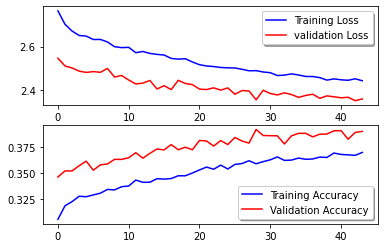

In [20]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation Loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [21]:
pred = np.argmax(model.predict(X_test), axis=1)
test_y = np.argmax(y_test, axis=1)

print(classification_report(test_y, pred, labels=list(range(len(labels)))))

              precision    recall  f1-score   support

           0       0.73      0.87      0.79        31
           1       0.46      0.55      0.50        22
           2       0.25      0.40      0.31        20
           3       0.26      0.17      0.21        35
           4       0.22      0.12      0.15        34
           5       0.29      0.27      0.28        26
           6       0.31      0.24      0.27        34
           7       0.53      0.60      0.56        30
           8       0.27      0.48      0.35        29
           9       0.50      0.39      0.44        28
          10       0.34      0.33      0.34        36
          11       0.36      0.22      0.28        36
          12       0.48      0.39      0.43        28
          13       0.16      0.22      0.18        27
          14       0.33      0.59      0.42        29
          15       0.17      0.09      0.12        34
          16       0.48      0.45      0.47        33
          17       0.42    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
